In [1]:
import gc
import os
import pickle
import gzip
import glob
import warnings
import itertools

warnings.simplefilter('ignore')

import netCDF4
import pandas as pd
import numpy as np
import pyart
import matplotlib.pyplot as pl

In [2]:
PATH_TO_GM_MODEL = '/home/548/vhl548/Jupyter/Investigator/in2019_v06/data/GM_model_radar_metechoes.pkl.gz'

In [3]:
def get_filter(radar, dbz_name='total_power',
                      zdr_name='differential_reflectivity',
                      phidp_name='differential_phase',
                      width_name='spectrum_width',
                      rhohv_name='cross_correlation_ratio'):
    '''
    Filters non-meteorological signal out using ML classification.
    
    Parameters:
    -----------
    radar: pyart-Radar object
    dbz_name: str (optional)
        Name of the total_power field.
    zdr_name: str (optional)
        Name of the differential_reflectivity field.
    phidp_name: str (optional)
        Name of the differential_phase field.
    width_name: str (optional)
        Name of the spectrum_width field.
    rhohv_name: str (optional)
        Name of the cross_correlation_ratio field.
        
    Returns:
    --------
    gf: pyart-gatefilter object
        GateFilter of the Meteorological echoes only.
    '''
    
    # Load Scikit model
    with gzip.GzipFile(PATH_TO_GM_MODEL, 'r') as gzid:
        meteorological_echoes_GMM = pickle.load(gzid)
    
    df_orig = pd.DataFrame({'total_power': radar.fields[dbz_name]['data'].flatten(),
                            'differential_reflectivity': radar.fields[zdr_name]['data'].flatten(),
                            'differential_phase': radar.fields[phidp_name]['data'].flatten(),
                            'spectrum_width': radar.fields[width_name]['data'].flatten(),
                            'cross_correlation_ratio': radar.fields[rhohv_name]['data'].flatten(),
                           })

    df = df_orig.dropna()

    pos_droped = df_orig.dropna().index
    radar_cluster = meteorological_echoes_GMM.predict(df_orig.dropna())

    r = radar.range['data']
    time = radar.time['data']
    R, T = np.meshgrid(r, time)

    clus = np.zeros_like(R.flatten())
    clus[pos_droped] = radar_cluster + 1
    cluster = clus.reshape(R.shape)

    meteorological_signal = ((cluster >= 5) | (cluster == 2))  # | ((R < 20e3) & ((cluster == 1) | (cluster == 4)))
    
    hydro_class = np.zeros(cluster.shape, dtype=np.int16)
    hydro_class[meteorological_signal] = 3
    hydro_class[((R < 20e3) & ((cluster == 1) | (cluster == 4)))] = 2
    hydro_class[(hydro_class == 0) & (cluster != 0)] = 1

    radar.add_field('good_mask', {'data': meteorological_signal})    

    gf = pyart.filters.GateFilter(radar)
    gf.exclude_equal('good_mask', 0)
    gf = pyart.correct.despeckle_field(radar, dbz_name, gatefilter=gf)
    _ = radar.fields.pop('good_mask')
    
    return gf, hydro_class

In [4]:
flist = sorted(glob.glob('/g/data/hj10/admin/opol/level_1/in2019_v06/**/*.*'))

In [5]:
radar = pyart.aux_io.read_odim_h5(flist[-825], file_field_names=False)

/home/548/vhl548/.local/miniconda3/envs/radar/lib/python3.8/site-packages/pyart/aux_io/odim_h5.py:295: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  start_time = datetime.datetime.utcfromtimestamp(start_epoch)


In [6]:
radar.fields.keys()

dict_keys(['total_power', 'velocity', 'spectrum_width', 'reflectivity', 'differential_reflectivity', 'cross_correlation_ratio', 'differential_phase', 'normalized_coherent_power', 'signal_to_noise_ratio'])

In [7]:
gf, clus = get_filter(radar)

In [12]:
clusmetadata = {'data': clus, 'standard_name': 'GMM Echo Classification'}

In [13]:
radar.add_field('cluster', clusmetadata, replace_existing=True)

In [14]:
gr = pyart.graph.RadarDisplay(radar)

In [15]:
clear_air = pyart.filters.GateFilter(radar)
clear_air.exclude_not_equal('cluster', 1)

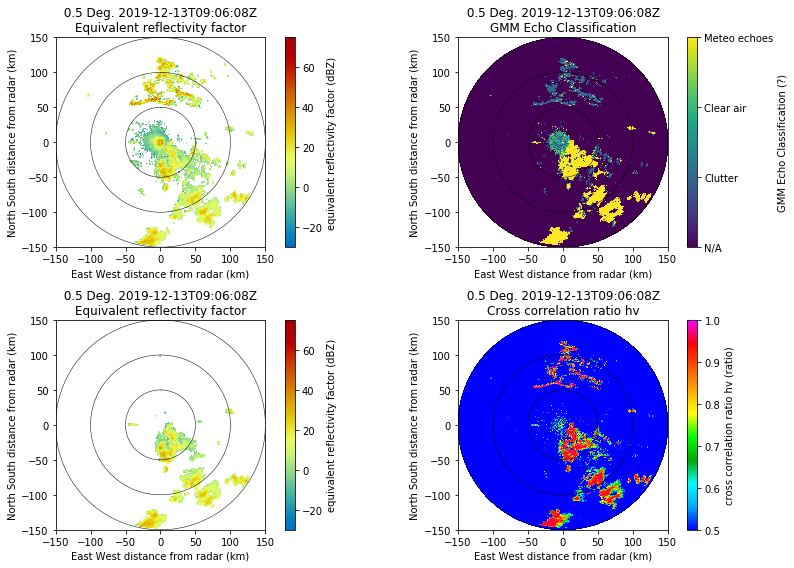

In [24]:
fig, ax = pl.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()
nsweep = 0

gr.plot_ppi('total_power', sweep=nsweep, ax=ax[0])
gr.plot_ppi('cluster', sweep=nsweep, ax=ax[1], ticks=[0, 1, 2, 3], ticklabs=['N/A', 'Clutter', 'Clear air', 'Meteo echoes'])
gr.plot_ppi('total_power', sweep=nsweep, ax=ax[2], gatefilter=gf)
gr.plot_ppi('cross_correlation_ratio', sweep=nsweep, ax=ax[3], vmin=0.5)

for a in ax:
    gr.plot_range_rings([50, 100, 150], ax=a, lw=0.5)
    a.set_aspect(1)
    a.set_xlim(-150, 150)
    a.set_ylim(-150, 150)

fig.tight_layout()
pl.savefig('GMM_echoclass')